# CNN for AED with Keras/TensorFlow

Date: March 2, 2019

Classification of acoustic events:

- Umai
- Mazui
- Oishii
- Others
- Silence

## Preparing data set for CNN

In [3]:
DATASET_FOLDER = '../dataset/data_restaurant'

%run ../oscilloscope/script/dataset.py

ds = DataSet(DATASET_FOLDER)
train_data, train_labels, test_data, test_labels = ds.generate()
shape = ds.shape
class_labels = ds.class_labels

In [4]:
shape

(64, 40)

### CNN model

In [5]:
from keras import layers
from keras import models

model = models.Sequential()

model.add(layers.Conv2D(4, (3, 3), activation='relu', input_shape=(*shape, 1)))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(8, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(class_labels), activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 38, 4)         40        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 19, 4)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 17, 8)         296       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 8, 8)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 6, 16)         1168      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 3, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 288)               0         
__________

In [6]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

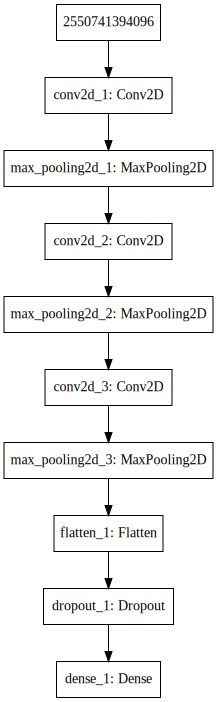

In [7]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

## Training CNN

In [8]:
EPOCHS = 100
history = model.fit(train_data, train_labels, epochs=EPOCHS, validation_data=(test_data, test_labels))

Train on 350 samples, validate on 150 samples
Epoch 1/100
350/350 [==============================] - 3s 9ms/step - loss: 1.5818 - acc: 0.2657 - val_loss: 1.5192 - val_acc: 0.3600
Epoch 2/100
350/350 [==============================] - 2s 6ms/step - loss: 1.5045 - acc: 0.3257 - val_loss: 1.4388 - val_acc: 0.5267
Epoch 3/100
350/350 [==============================] - 2s 6ms/step - loss: 1.4153 - acc: 0.4457 - val_loss: 1.3481 - val_acc: 0.6333
Epoch 4/100
350/350 [==============================] - 2s 6ms/step - loss: 1.3306 - acc: 0.4800 - val_loss: 1.2416 - val_acc: 0.6400
Epoch 5/100
350/350 [==============================] - 2s 7ms/step - loss: 1.2536 - acc: 0.5314 - val_loss: 1.1536 - val_acc: 0.6333
Epoch 6/100
350/350 [==============================] - 2s 6ms/step - loss: 1.1955 - acc: 0.5514 - val_loss: 1.0494 - val_acc: 0.6533
Epoch 7/100
350/350 [==============================] - 2s 6ms/step - loss: 1.1022 - acc: 0.5600 - val_loss: 0.9671 - val_acc: 0.7067
Epoch 8/100
350/350 [==

Epoch 62/100
350/350 [==============================] - 2s 6ms/step - loss: 0.0974 - acc: 0.9743 - val_loss: 0.0907 - val_acc: 0.9733
Epoch 63/100
350/350 [==============================] - 2s 5ms/step - loss: 0.0798 - acc: 0.9800 - val_loss: 0.0817 - val_acc: 0.9667
Epoch 64/100
350/350 [==============================] - 2s 7ms/step - loss: 0.0940 - acc: 0.9714 - val_loss: 0.0935 - val_acc: 0.9667
Epoch 65/100
350/350 [==============================] - 2s 6ms/step - loss: 0.0786 - acc: 0.9743 - val_loss: 0.0977 - val_acc: 0.9733
Epoch 66/100
350/350 [==============================] - 2s 6ms/step - loss: 0.0746 - acc: 0.9686 - val_loss: 0.0993 - val_acc: 0.9667
Epoch 67/100
350/350 [==============================] - 2s 6ms/step - loss: 0.0753 - acc: 0.9800 - val_loss: 0.1220 - val_acc: 0.9600
Epoch 68/100
350/350 [==============================] - 2s 6ms/step - loss: 0.0719 - acc: 0.9686 - val_loss: 0.1152 - val_acc: 0.9667
Epoch 69/100
350/350 [==============================] - 2s 6ms

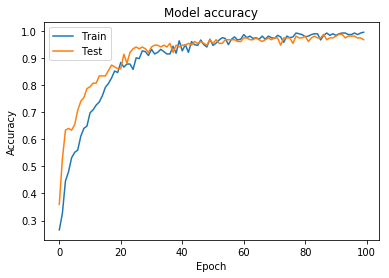

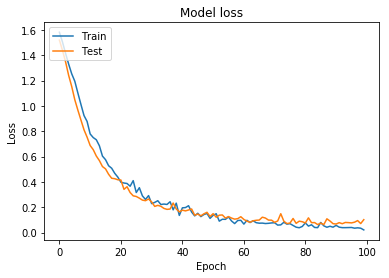

In [9]:
%run history.py
%matplotlib inline

plot_accuracy(history)
plot_loss(history)

## Save the model

In [11]:
import datetime

dt = datetime.datetime.today().strftime('%Y%m%d%H%M%S')
filename = DATASET_FOLDER + '/cnn_for_aed_restaurant{}.h5'.format(dt)
model.save(filename)

## Load the model

In [12]:
del model
model = models.load_model(filename)

## Confirmation

In [13]:
import numpy as np
import matplotlib.pyplot as plt
train_data.shape

(350, 64, 40, 1)

In [14]:
layer_outputs = [layer.output for layer in model.layers]
#layer_outputs

In [15]:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(test_data)
#activations[0][0,:,:,0].shape

In [16]:
class_labels

['umai', 'mazui', 'oishii', 'silence', 'others']

In [17]:
(activations[-1][:10]*100).astype(int)

array([[99,  0,  0,  0,  0],
       [ 0, 99,  0,  0,  0],
       [ 0,  0,  4,  0, 95],
       [ 0,  0,  0, 99,  0],
       [ 0, 99,  0,  0,  0],
       [ 0, 99,  0,  0,  0],
       [ 0,  0,  0, 99,  0],
       [ 0,  0,  0, 99,  0],
       [ 0,  0, 99,  0,  0],
       [ 0,  0,  0,  0, 99]])

In [18]:
test_labels[:10].astype(int)

array([[1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1]])

In [19]:
def plot_layer(activations, sample, layer):
    a = activations[layer].shape
    rows = int(a[3]/4)
    fig, axarr = plt.subplots(rows, 4, figsize=[20,15])
    for i in range(a[3]):
        row = int(i/4)
        x, y = row, i-4*row
        axarr[x, y].imshow(np.rot90(activations[layer][sample, :, :, i]))
        axarr[x, y].set_xticks([])
        axarr[x, y].set_yticks([])

'others'

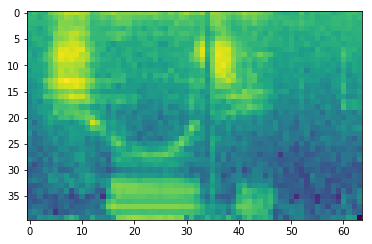

In [20]:
image_number = 29

plt.imshow(np.rot90(test_data[image_number,:,:,0]))
class_labels[np.argmax(test_labels[image_number])]

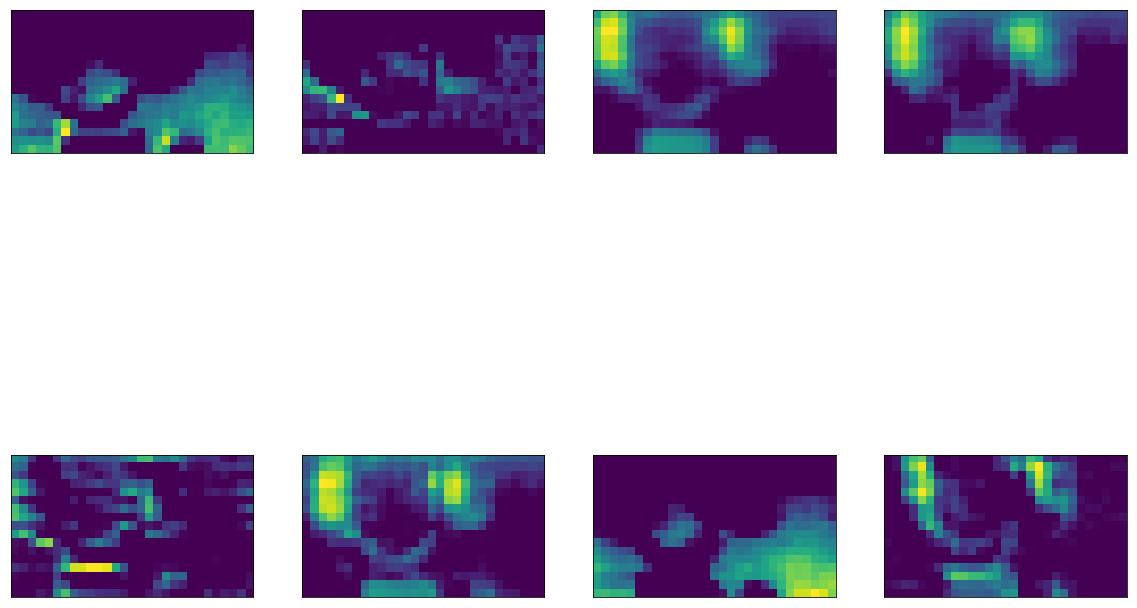

In [21]:
plot_layer(activations, image_number, 2)

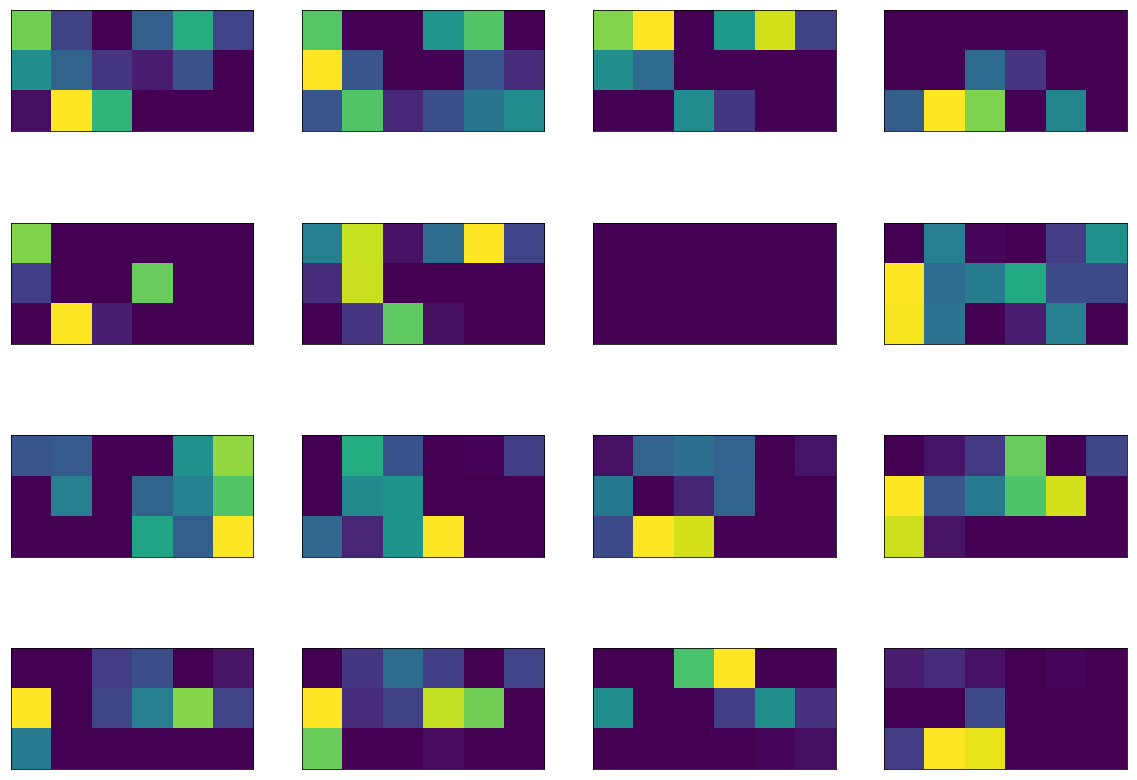

In [22]:
plot_layer(activations, image_number, 5)